<a href="https://colab.research.google.com/github/HoschangNoori/my-first-blog/blob/master/Exercise_07_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Temporal and Spatial DataMining


## Exercise_07_Segmentation

**Task 1**

**a)**  Why is a segmentation procedure useful in processing time series data, and what is the difference between **online** and **offline** segmentation? 

Answer:  
* Splitting longer sequences (Time Series) into shorter sections (segments)
* It's useful for data reduction and finding out the underlying truth of the time series
* online segmentation: segment the data in a process where new data can come in
* offline segmentation: segment all the data at once

**b)** What are the differences between top-down segmentation, bottom-up segmentation and sliding-window segmentation? When does it make sense to use a particular process?

Answer: 
* Top-Down and Buttom-Up Segmentation Techniques are Offline Methods while Sliding-Wndow Segmentation is a Online Method
* Top Down: Start from one segment -> split the segment til stopping criterion is met. Results can be disconnected and non-overlapping
* Buttom Up: Start from as much segments as possible -> unite the segments until stopping criterion is met. Results can be disconnected and non-overlapping
* Sliding Window: Move a window of fixed length w with step-length s over the data points, observate certain attributes like slope and curvature to make segmentation decision. Results can be overlapping and connected
\\
* Sliding WIndow: Real Time Systems, Segmentation at changes
* Top-Down, Buttom-Up: Efficiency, smallest possible approximation error


**Task 2: Bottom-up, top-down and sliding-window segmentation**

In [270]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.use('ggplot')

from ipywidgets import interact
import ipywidgets as widgets

In [271]:
with open("/content/drive/MyDrive/exercise07/data/ecg.txt") as f:
    file_lines = f.readlines()

y = np.array([float(x.split("\t")[2].strip()) for x in file_lines[100:320]])
x = np.arange(1, len(y) + 1)

In [272]:
def draw_plot(x, y, plot_title):
    plt.figure(figsize=(12,5))
    plt.plot(x, y, alpha=0.8, color='blue')
    plt.title(plot_title)
    plt.xlabel("Samples")
    plt.ylabel("Signal")

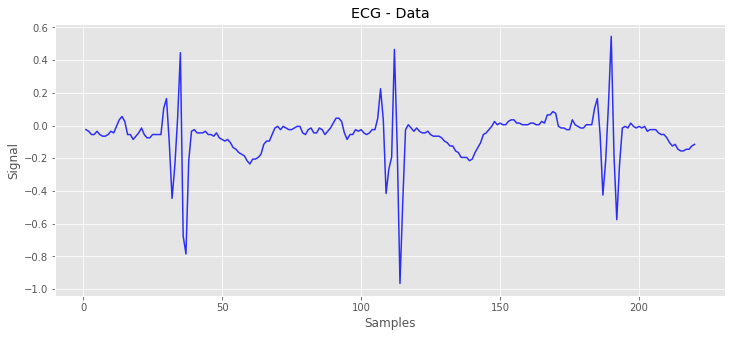

In [273]:
draw_plot(x, y,"ECG - Data")

**a)** Implement following functions

- Implement a function with the name `regression` to fit a line into a given segment of a sequence using linear regression

- Implement a cost function with the name `sumsquared_error` to calculate the squared sum of errors for a fitted line into a segment of a sequence

> **Hint:** [`numpy.linalg.lstsq`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html)

In [274]:
from numpy.linalg import lstsq

In [303]:
def regression(x, y, interval):
  # interval 2x1 vector for example: [0 50]
  int1 = interval[0]
  int2 = interval[1]

  x_int = x[int1:int2]
  y_int = y[int1:int2]
  A = np.vstack([x_int, np.ones(len(x_int))]).T
  m, c = lstsq(A, y_int, rcond=None)[0]
  return x_int, m, c


def sumsquared_error(x, y, interval):
  int1 = interval[0]
  int2 = interval[1]

  x_int = x[int1:int2]
  y_int = y[int1:int2]
  A = np.vstack([x_int, np.ones(len(x_int))]).T
  return lstsq(A, y_int, rcond=None)[1]

[1.66666667e-05]


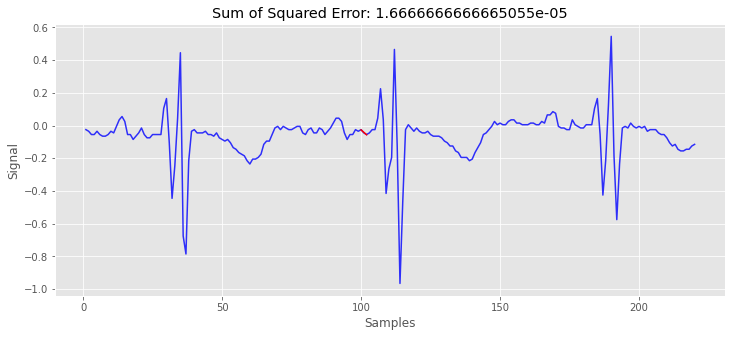

In [300]:
interval = [100, 103]
x_int, m, c = regression(x, y, interval)
sse = sumsquared_error(x, y, interval)
print(sse)
draw_plot(x, y,"ECG - Data")
plt.plot(x_int, m*x_int + c, 'r', label='Fitted line')
plt.title('Sum of Squared Error: ' + str(sse[0]))
plt.show()

**b)** Create a function`bottomupsegment`, which return a list of segments using the bottom-up technique

>**Hint:** The following functions should return a list of segments. Each Segment contains four values of the fitted line:

    [(x0, y0, x1, y1), ... , (x0, y0, x1, y1)]

In [359]:
def bottomupsegment(y, regression, sumsquared_error, max_error):
  # 1) create initial fine approximation
  Seg_TS = []
  for i in range(0, len(y)-2, 2):
      Seg_TS.append([i, i+2])

  # 2) Find cost of merging each pair of segments.
  merge_cost = []
  for i in range(0, len(Seg_TS)-1, 1):
    sse = sumsquared_error(x, y, [min(Seg_TS[i]), max(Seg_TS[i+1])])
    merge_cost.append(sse[0])

  # 3) Find cheapest pair to merge
  while min(merge_cost) < max_error:
    index = np.argmin(merge_cost)
    if index+1 < len(merge_cost):
      Seg_TS[index] = [Seg_TS[index][0], Seg_TS[index+1][1]]
      del(Seg_TS[index+1])
      sse = sumsquared_error(x, y, [Seg_TS[index][0], Seg_TS[index+1][1]])
      merge_cost[index] = sse[0]
      del(merge_cost[index+1])
    else:
      Seg_TS[index-1] = [Seg_TS[index-1][0], Seg_TS[index][1]]
      del(Seg_TS[index])

      sse = sumsquared_error(x, y, [Seg_TS[index-1][0], Seg_TS[index][1]])
      merge_cost[index-1] = sse[0]
      del(merge_cost[index])

  outputs= []
  for segment in Seg_TS:
    idx1 = segment[0]
    idx2 = segment[1]
    _, m, c = regression(x, y, segment)
    output = [idx1, m*idx1+c, idx2, m*idx2+c]
    outputs.append(output)
  return outputs

**c)** Create a function `topdownsegment`, which return a list of segments using the top-down technique

77

**d)** Create a function `slidingwindowsegment`, which return a list of segments using the sliding-window technique

In [ ]:
### Your Code here ###

**e)** Use the following functions to plot the resulting segmentation procedure considering different error thresholds.

- Explain the results

In [360]:
from ipywidgets import interact
import ipywidgets as widgets

In [361]:
def draw_segments(segments):
    ax = plt.gca()
    for segment in segments:
        line = Line2D((segment[0],segment[2]),(segment[1],segment[3]))
        ax.add_line(line)

In [362]:
data = y

def bottom_up_with_reg(max_error):
    #bottom-up with regression
    plt.figure(figsize=(20,8))
    max_error = max_error/100
    print('maximal error: ', max_error)
    
    segments = bottomupsegment(data, regression, sumsquared_error, max_error)
    draw_plot(x, y,"Bottom-up with regression")
    draw_segments(segments)
    
def top_down_with_reg(max_error):

    #top-down with regression
    plt.figure(figsize=(20,8))
    max_error = max_error/100
    
    print('maximal error: ', max_error)
    segments = topdownsegment(data, regression, sumsquared_error, max_error)
    draw_plot(x, y,"Top-down with regression")
    draw_segments(segments)
    
def sliding_window_with_reg(max_error):
    #sliding window with regression
    plt.figure(figsize=(20,8))
    max_error = max_error/100
    print('maximal error: ', max_error)
    
    segments = slidingwindowsegment(data, regression, sumsquared_error, max_error)
    draw_plot(x, y,"Sliding window with regression")
    draw_segments(segments)
    plt.show()

In [363]:
interact(bottom_up_with_reg, max_error=widgets.IntSlider(min=1, max=100, size=101, step=1, value=0.001))

interactive(children=(IntSlider(value=1, description='max_error', min=1), Output()), _dom_classes=('widget-int…

<function __main__.bottom_up_with_reg>

In [ ]:
interact(top_down_with_reg, max_error=widgets.IntSlider(min=1, max=100, size=101, step=1, value=0.001))

interactive(children=(IntSlider(value=1, description='max_error', min=1), Output()), _dom_classes=('widget-int…

<function __main__.top_down_with_reg(max_error)>

In [ ]:
interact(sliding_window_with_reg, max_error=widgets.IntSlider(min=1, max=100, size=101, step=1, value=0.001))

interactive(children=(IntSlider(value=1, description='max_error', min=1), Output()), _dom_classes=('widget-int…

<function __main__.sliding_window_with_reg(max_error)>

**f)** Further Segmentation techniques

Consider the shape of the following signal. Which segmentation procedure is suitable in this case?

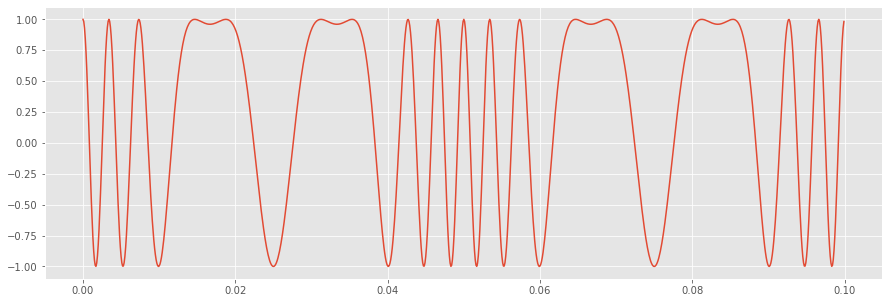

In [ ]:
Fs = 10000
fc = 100 
fm = 20
b = 10

t = np.arange(0, 0.1, 1/Fs)
fm = np.cos(2*np.pi*fc*t + b*np.sin(2*np.pi*fm*t))

plt.figure(figsize=(15,5))
plt.plot(t, fm)
plt.show()

**Task 3: Optimal Segmentation and SWAB** (Bonus)

**a)** Practice the example for the optimal segmentation from the lecture again on a paper, preferably at home.

In [ ]:
x = np.array([1., 2., 3., 4., 5., 6., 7.])
y = np.array([2., 5., 4., 6., 3., 1., 4.])

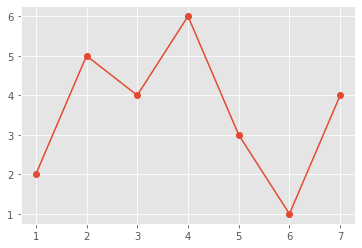

In [ ]:
plt.figure()
plt.plot(x,y, '-o')
plt.show()

**b)** Implement the optimal segmentation in Python.

In [ ]:
### Your Code here ###

**c)** Describe the SWAB algorithm.

>Paper: "An Online Algorithm for Segmenting Time Series"